In [ ]:
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
import io
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.io import wavfile

import numpy as np
import pandas as pd
import soundfile as sf
import torch.nn.functional as F
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim

import os
from tqdm import tqdm
import pickle

from librosa.feature import melspectrogram
from librosa.core import load as load_wav
from librosa import power_to_db
import librosa
from librosa.display import specshow


def read_from_zip(zip_store, filename):
    with io.BytesIO() as bytes_buff:
        bytes_data = zip_store.read(filename)
        bytes_buff.write(bytes_data)
        bytes_buff.seek(0)
        sr, wave = wavfile.read(bytes_buff)
    return sr, wave

dataset = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/audio_train.zip')
datalabels = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv")
filelist = dataset.namelist()
file10 = filelist[1:]


# from utils.preprocessing import extract_log_mel_feats
# run git log чтобы посмотреть предыдущие версии кода, где не было исправлений

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def extract_log_mel_feats(set_type, path_to_csv, out_path, sr, fft_size, hop, n_mels):
    """
    Extract features from given files and store them in binary format.

    :param set_type:
    :param path_to_csv: path to loaded csv
    :param path_to_files: path to loaded data
    :param out_path: path to store extracted features
    :param sr: input files sample rate
    :param fft_size: size of fft window
    :param hop: hop size
    :param n_mels: number of mel band

    :return:

    """
    dataset = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/audio_train.zip')
    #datalabels = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv")

    set_type = set_type.lower()
    if set_type not in ['train', 'test']:
        raise Exception('Such set type not supported: {}'.format(set_type))

    feats = []

    if set_type == 'train':
        meta = pd.read_csv(path_to_csv, skiprows=1, names=['fname', 'label', 'manually_verified'])

        file_names = list(meta['fname'])
        n_files = len(file_names)
        labels = list(meta['label'])

        uniq_labels = np.sort(np.unique(labels))
        label_to_id = {label: i for i, label in enumerate(uniq_labels)}

        print('Total files:', n_files)

        for i, (file_name, label) in tqdm(enumerate(zip(file_names, labels))):
            file_name = 'train/' + file_name
            sr, wav_data = read_from_zip(dataset,file_name)
            mel_spec = melspectrogram(wav_data, n_fft=fft_size, hop_length=hop, n_mels=n_mels, fmax=sr // 2)
            log_mel_spec = power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
                'label_id': label_to_id[label]
            })
        pickle.dump(feats, open(out_path, 'wb'))    
        return label_to_id
    else:
        for i, file_name in tqdm(enumerate(os.listdir(path_to_files))):
            sr, wav_data = read_from_zip(dataset,file_name)
            if len(wav_data) == 0:
                # print('Empty file:', file_name)
                wav_data = np.zeros(sr)
            mel_spec = melspectrogram(wav_data, n_fft=fft_size, n_mels=n_mels, fmax=sr // 2)
            log_mel_spec = power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
            })

    pickle.dump(feats, open(out_path, 'wb'))

13    Computer_keyboard
Name: label, dtype: object


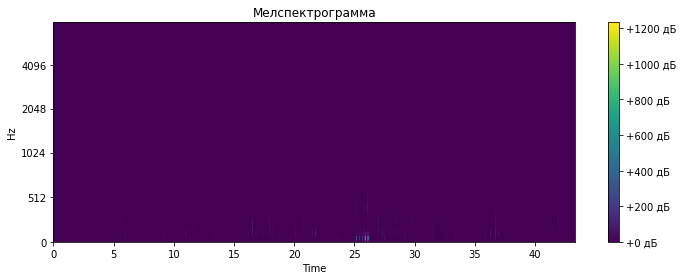

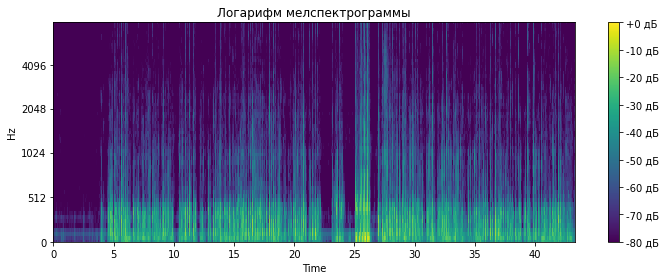

In [ ]:
sample_rate = 11025
fft_size = 1024
overlap = 4
hop = fft_size // overlap
mels = 64

filepath = file10[1]
file_name = filepath[6:]
sr, wav_data = read_from_zip(dataset,filepath)
mel_spec = melspectrogram(wav_data, n_fft=fft_size, hop_length=hop, n_mels=mels, 
                          fmax=sample_rate//2)
print(datalabels["label"][datalabels["fname"] == file_name])
plt.figure(figsize=(10, 4))
colors = 'viridis'
specshow(mel_spec, y_axis='mel', fmax=sr//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Мелспектрограмма')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
specshow(power_to_db(mel_spec, ref=np.max), y_axis='mel',
         fmax=sr//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Логарифм мелспектрограммы')
plt.tight_layout()
plt.show()

In [ ]:
path_to_csv = "/content/drive/MyDrive/Colab Notebooks/train.csv"

pickle_train_path = "/content/drive/MyDrive/Colab Notebooks/train.pickle"
# pickle_test_path = os.path.join('./data', 'test.pickle')

label_to_id = extract_log_mel_feats('train', path_to_csv,pickle_train_path, sample_rate, fft_size, hop, mels)
id_to_label = [label for label, i in label_to_id.items()]



# extract_log_mel_feats('test', '', test_folder, pickle_test_path, sample_rate, fft_size, hop, mels)

2it [00:00, 13.39it/s]

Total files: 5683


5683it [02:36, 36.33it/s]


In [ ]:



class DummyNetwork(nn.Module):
    def __init__(self):
        super(DummyNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=(1, 1))
        
        self.mp = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.3)
        
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.bn2 = nn.BatchNorm2d(num_features=96)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        
        self.flat = nn.Flatten()
        
        # 33856 - должно соответствовать форме self.flat
        self.fc1 = nn.Linear(33856, 41)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout3(x)
        
        x = self.flat(x)
        # здесь можно еще добавить полносвязных слой или слои
        x = self.fc1(x)
        return x


In [ ]:
random_input = torch.randn(1, 1, 64, 64, requires_grad=True)
network = DummyNetwork()
output = network(random_input)
print(output)

tensor([[-0.1120,  0.0359, -0.2264,  0.0940,  0.3357, -1.1100, -0.5017,  1.6211,
         -0.3016,  0.3778, -0.0161,  0.2590, -0.3950,  1.1878, -1.0792,  0.5435,
         -2.4251,  0.8078, -0.8639,  0.5932, -0.1855,  1.3151,  0.5518, -0.4176,
          0.8877, -1.4001,  1.7805, -0.6545,  0.1641,  0.4920, -0.3670, -0.3624,
         -0.4662,  1.3431, -1.2438, -0.2952, -1.0981, -1.2676, -0.6286, -0.4913,
         -0.2204]], grad_fn=<AddmmBackward>)


In [ ]:



criterion = nn.CrossEntropyLoss()

#optimizer = optim.SGD(network.parameters(), lr=0.001)
optimizer = optim.Adam(network.parameters(), lr=0.001)
optimizer.zero_grad()

random_input = torch.randn(3, 1, 64, 64, requires_grad=True)

output = network(random_input)
target = torch.empty(3, dtype=torch.long).random_(5)

loss = criterion(output, target)

print(loss.item())

loss.backward()
optimizer.step() 

3.7464401721954346


In [ ]:
import pickle

pickle_train_data = pickle.load(open(pickle_train_path, 'rb'))

In [ ]:
def prepare_shape(feature):
    tmp = feature
    N = 64 # размер во времени (можно увеличить, должно стать лучше)
    while tmp.shape[1] < N:
        # можно попробовать сделать np.pad для коротких файлов, вместо повторения до необходимой длины
        #tmp = np.pad(tmp,[(0,N - len(tmp))],mode="constant")
        tmp = np.hstack((tmp, tmp))
    # случайный сдвиг должен улучшить результат (для этого нужно функцию перенести в EventDetectionDataset)
    tmp = tmp[np.newaxis, :, :N]
    return tmp

In [ ]:
# можно улучшить, используя сбалансированное валидационное множество
# гуглить stratified train test split sklearn
validation_set_size = 800

x_val = []
y_val = []

x_tr = []
y_tr = []

for i, row in enumerate(pickle_train_data):
    feature = prepare_shape(row['feature'])
    if i < validation_set_size:
        x_val.append(feature)
        y_val.append(row['label_id'])
    else:
        x_tr.append(feature)
        y_tr.append(row['label_id'])
x_val = np.asarray(x_val)
x_tr = np.asarray(x_tr)

y_val = np.asarray(y_val)
y_tr = np.asarray(y_tr)

In [ ]:



class EventDetectionDataset(Dataset):
    def __init__(self, x, y=None):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # добавить сюда prepare_shape()
        if self.y is not None:
            return self.x[idx], self.y[idx]
        return self.x[idx]

In [ ]:
train_dset = EventDetectionDataset(x_tr, y_tr)
val_dset = EventDetectionDataset(x_val, y_val)

14


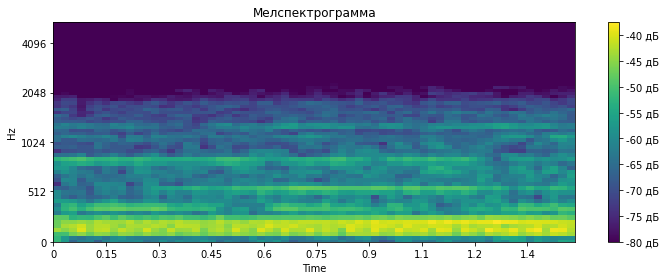

In [ ]:
sample_x, sample_y = val_dset[2]
print(sample_y)
# print(id_to_label[sample_y])
plt.figure(figsize=(10, 4))
colors = 'viridis'
specshow(sample_x[0], y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Мелспектрограмма')
plt.tight_layout()
plt.show()

In [ ]:


train_loader = DataLoader(train_dset, batch_size=41, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dset, batch_size=41, shuffle=False, num_workers=0)

In [ ]:
n_epoch = 100
criterion = nn.CrossEntropyLoss()
network = DummyNetwork()
# можно попробовать другой optimizer, тоже считается улучшением
#optimizer = optim.SGD(network.parameters(), lr=0.001)
optimizer = optim.Adam(network.parameters(), lr=0.001)
train_loss = []
val_loss = []

train_acc = []
val_acc = []

for e in range(n_epoch):
    print('epoch #', e)
    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()
        x = x.type(torch.FloatTensor)

        output = network(x)
        outputs.append(output.detach().numpy().argmax(axis=1))
    
        target = y
        targets.append(target)
        
        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    y_true = np.hstack(targets)
    y_pred = np.hstack(outputs)
    acc = accuracy_score(y_true, y_pred)
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    print('mean train loss:', train_loss[-1])
    print('train accuracy:', acc)
    
    
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x, y = sample_batched
            optimizer.zero_grad()
            x = x.type(torch.FloatTensor)

            output = network(x)
            outputs.append(output.detach().numpy().argmax(axis=1))

            target = y
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
#             loss.backward()
#             optimizer.step()
            
        y_true = np.hstack(targets)
        y_pred = np.hstack(outputs)
        acc = accuracy_score(y_true, y_pred)
        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        print('mean val loss:', val_loss[-1])
        print('val accuracy:', acc)

epoch # 0
mean train loss: 9.66494392156601
train accuracy: 0.14028261314765514
mean val loss: 5.5135882019996645
val accuracy: 0.185
epoch # 1
mean train loss: 5.210234344005585
train accuracy: 0.22957198443579765
mean val loss: 4.893349587917328
val accuracy: 0.2
epoch # 2
mean train loss: 4.293551907936732
train accuracy: 0.2842514847429859
mean val loss: 3.772991943359375
val accuracy: 0.26375
epoch # 3
mean train loss: 3.348899735013644
train accuracy: 0.34507474912963343
mean val loss: 2.9289711892604826
val accuracy: 0.32875
epoch # 4
mean train loss: 2.5892901718616486
train accuracy: 0.40385009215646117
mean val loss: 2.7271077752113344
val accuracy: 0.3425
epoch # 5
mean train loss: 2.203388985494773
train accuracy: 0.4357976653696498
mean val loss: 2.3680038452148438
val accuracy: 0.41875
epoch # 6
mean train loss: 1.8408097883065542
train accuracy: 0.49682572189227936
mean val loss: 2.2333202004432677
val accuracy: 0.42125
epoch # 7
mean train loss: 1.6862472712993621
train

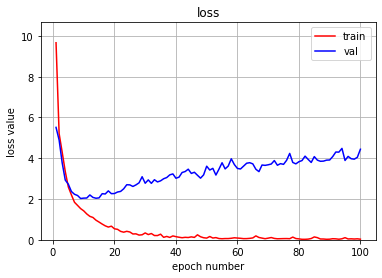

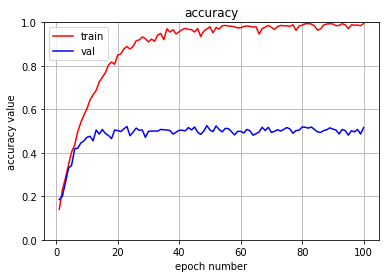

In [ ]:
epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()